# Procesamiento de tomografía eléctrica en pyGIMLi

PyGIMLi es una librería de código abierto para modelado e inversión de datos geofísicos. En este [link](https://www.pygimli.org/about.html#sec-gimli) pueden consultar toda la información de la librería.
Para métodos eléctricos, en particular para tomografía eléctrica, usaremos la librería `physics`.
Pueden consultar la documentación de los módulos y funciones [aquí](https://www.pygimli.org/pygimliapi/_generated/pygimli.physics.html#module-pygimli.physics).

Lo primero que vamos a hacer siempre en nuestro archivo es importar las librerías que vamos a usar.

In [2]:
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

Ahora vamos a usar el módulo [ERT](https://www.pygimli.org/pygimliapi/_generated/pygimli.physics.ert.html#module-pygimli.physics.ert) para trabajar con los datos eléctricos, pueden revisar la documentación de las funciones. Lo primero que haremos es cargar el archivo de datos que obtuvimos en la prepa anterior.

In [3]:
data = ert.load('data_UDF.csv')
print(type(data))

<class 'pgcore._pygimli_.DataContainerERT'>


Con la función ``type`` podemos ver el tipo de archivo, en este caso, observamos que ``data``, variable donde leímos el archivo de tomografía, es un contenedor de PyGIMLi, que es específico para tomografía eléctrica. Si hay algún error en el formato de nuestros datos, la función ``ert.load()`` no funcionaría, y nos arrojaría un error al correr el código. También podemos comprobar que nuestros datos se están leyendo de forma correcta:

In [4]:
print(data)

Data: Sensors: 17 data: 105, nonzero entries: ['a', 'b', 'i', 'm', 'n', 'rhoa', 'sd', 'sp', 'u', 'valid']


Y también ver nuestros datos sin invertir:

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1cb26ebd370>)

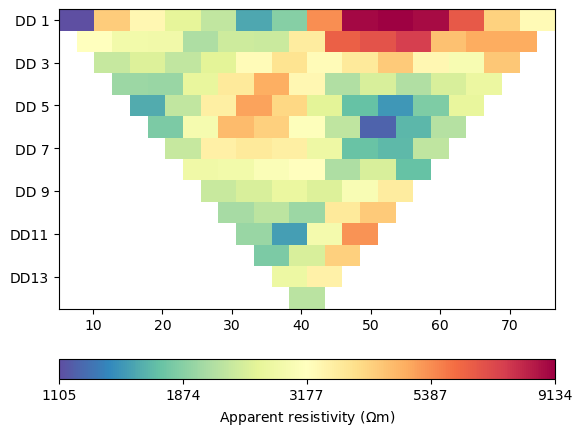

In [5]:
ert.show(data)

Y la posición de los electrodos y topografía:

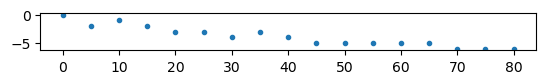

In [6]:
fig, ax = plt.subplots()
ax.plot(pg.x(data), pg.z(data),'.')
ax.set_aspect(1)
plt.show()

Ahora vamos a calcular el factor geométrico numérico y analítico de nuestros datos, valores que vamos a utilizar para ver el efecto de la topografía en los datos. Para ello, usamos una función del módulo ``ert``, donde el parámetro ``numerical`` es el que determina si tendremos un valor numérico o no, y ``data`` son nuestros datos.

In [7]:
k_num = ert.createGeometricFactors(data, numerical=True)
k_ana = ert.createGeometricFactors(data, numerical=False)
data['k']=k_num

24/06/24 - 09:26:21 - pyGIMLi - INFO - Cache c:\Users\Oriana\miniconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.6s x 2): C:\Users\Oriana\AppData\Roaming\pygimli\Cache\12229024977018359900


24/06/24 - 09:26:21 - pyGIMLi - INFO - Cache c:\Users\Oriana\miniconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 2): C:\Users\Oriana\AppData\Roaming\pygimli\Cache\16189428005786139390


Ahora podemos ver el efecto de la topografía en los datos:

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1cb27478910>)

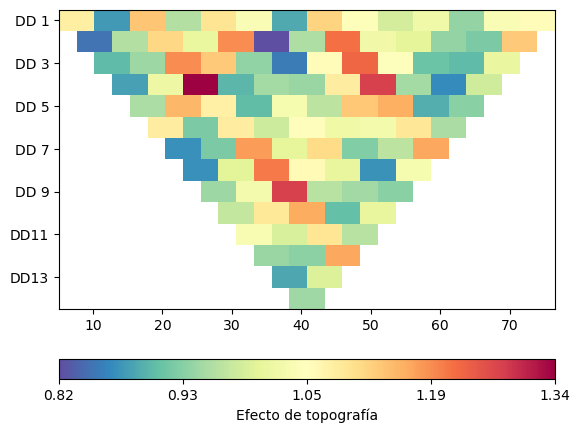

In [8]:
ert.show(data, vals=k_num/k_ana, label='Efecto de topografía',logscale=True)

Ahora calculamos el error de los datos. Cabe a destacar que la desviación estándar que está en los datos NO es el error de los datos, este se tiene que determinar dependiendo de las magnitudes y los resultados que queremos obtener de la inversión. Para calcular este error, usaremos la función ``ert.estimateError()``, donde los parámetros ``relativeError``, ``absoluteError``, y ``absoluteUError`` son parámetros que se escogen dependiendo de nuestros datos. 
Luego, filtramos aquellos puntos donde el error sea mayor a 0.5, mostramos la figura en término de porcentajes al multiplicar por 100, y guardamos la figura.

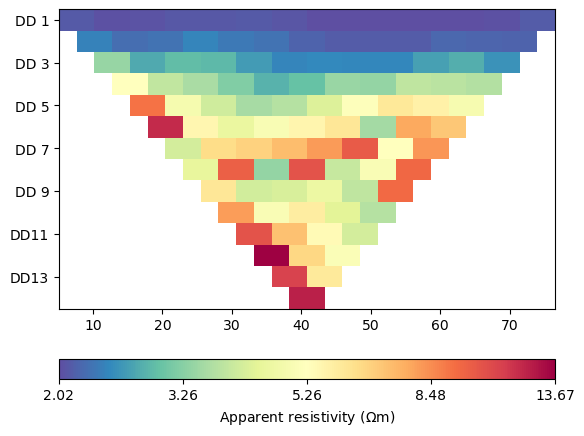

In [9]:
data['err'] = ert.estimateError(data, relativeError=0.02,absoluteError=2, absoluteUError=0.2)
data.remove(data['err']>0.5)
ert.show(data, data['err']*100)
plt.savefig('error.png')

Ahora ya hemos calculado todos los parámetros de nuestros datos que necesitamos para hacer la inversión. Para ello, utilizamos la función ``ert.ERTManager()``, que inicia el módulo que hará la inversión.

In [10]:
mgr = ert.ERTManager(data)

Ahora, corremos la inversión con la función ``invert``, que recibe nuestros datos como parámetro, además de ``lam``, que es parámetro de la regularización, ``quality``, que es la calidad del modelo, ``paraMaxCellSize``, el mayor tamaño de celda permitido. Estos valores se ajustan dependiendo de los resultados que queremos, y es a "ojo", los demás parámetros se dejan como están.

In [11]:
mod = mgr.invert(data, lam=8, stopAtChi1 = True, verbose = True,quality=34.5, 
                 paraMaxCellSize = 1, robustData = True)

24/06/24 - 09:26:23 - pyGIMLi - INFO - Found 2 regions.
24/06/24 - 09:26:23 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/06/24 - 09:26:23 - pyGIMLi - INFO - Found 2 regions.
24/06/24 - 09:26:23 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/06/24 - 09:26:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/06/24 - 09:26:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/06/24 - 09:26:25 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 44108 Cells: 87900 Boundaries: 66082
24/06/24 - 09:26:26 - pyGIMLi - INFO - Use median(data values)=2758.0
24/06/24 - 09:26:26 - pyGIMLi - INFO - Created startmodel from forward operator: 18449, min/max=2758.000000/2758.000000
24/06/24 - 09:26:26 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001CB2712F2C0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001CB271C4950>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001CB271C4BD0>
min/max (data): 1105/9134
min/max (error): 2.02%/13.67%
min/max (start model): 2758/2758
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  279.94
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   12.75 (dPhi = 94.35%) lam: 8.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    2.05 (dPhi = 70.34%) lam: 8.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.91 (dPhi = 16.79%) lam: 8.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)      

Verán que les tomará un tiempo correr el código, esto depende, principalmente, de los valores que hayamos escogido de ``quality`` y ``lam``. Pueden leer más sobre los parámetros [aquí]('https://www.pygimli.org/pygimliapi/_generated/pygimli.physics.ert.html#pygimli.physics.ert.ERTManager'). 
Luego de correr la inversión, vamos a ver su resultado, junto con los datos crudos y la bondad del ajuste del modelo, para lo que usamos la función ``showResultAndFit()``. Veremos dos variables: 
- RRMSE, que preferiblemente debe estar entre 0 - 5%.
- $\chi^2$, que debe ser cercano a 1.
En este caso, esto se cumple porque ya elegí los valores de la inversión a priori, pero cuando ustedes estén invirtiendo sus propios datos, van a necesitar jugar con los parámetros hasta obtener el resultado deseado.
Luego, guardamos la imagen con la función ``savefig()`` con el nombre que queremos.

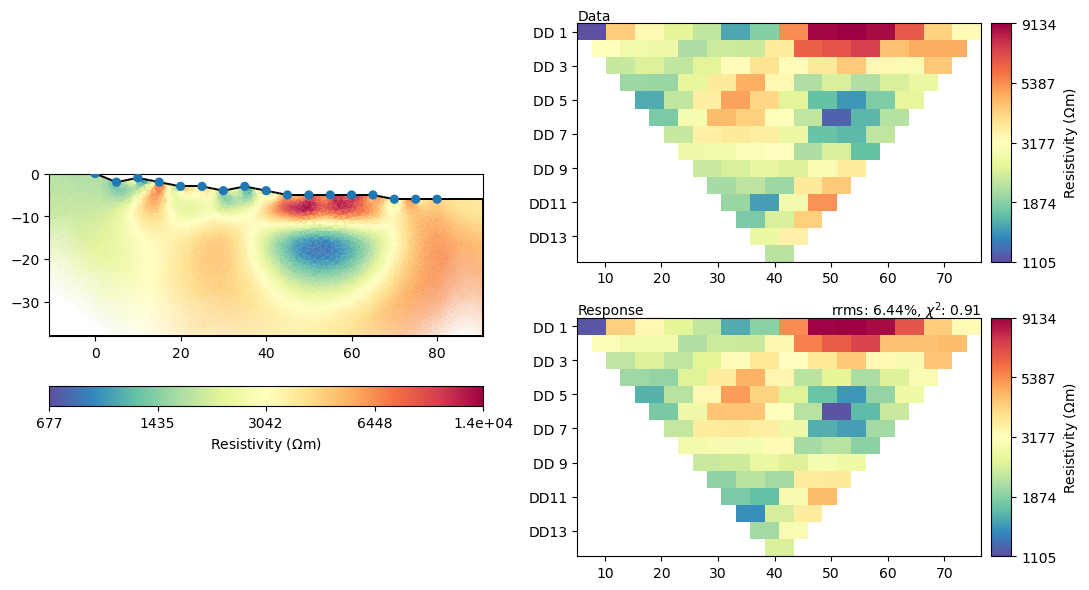

In [12]:
mgr.showResultAndFit()
plt.savefig('fit_and_model.png')

Finalmente, podemos guardar nuestra tomografía y ajustar las etiquetas de los ejes como queramos, incluso podemos cambiar la paleta de colores, [aquí](https://matplotlib.org/stable/users/explain/colors/colormaps.html) pueden ver los que están disponibles. Ahora solo resta guardar la imagen, ¡y listo!

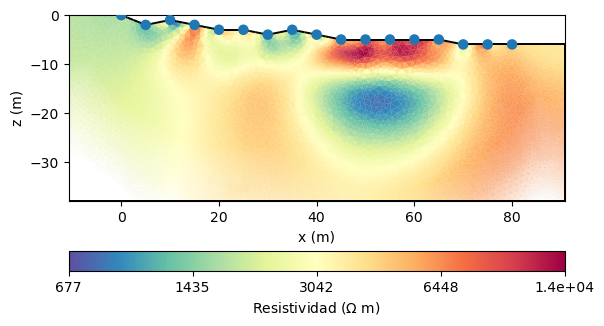

In [14]:
mgr.showResult(mod, label="Resistividad ($\\Omega$ m)", 
            xlabel = 'x (m)', ylabel = 'z (m)')

plt.savefig('result.png')